# Predicting Pathogen from RNAseq data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pow
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC

random_state = 7

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

patient_groups=["control", "viral", "bacterial", "fungal"]
group_id = lambda name: patient_groups.index(name)

X = pd.DataFrame.from_csv("combineSV_WTcpmtable_v2.txt", sep="\s+").T
y = [group_id("bacterial")] * 29 \
    + [group_id("viral")] * 42 \
    + [group_id("fungal")] * 10 \
    + [group_id("control")] * 61

#y = MultiLabelBinarizer().fit_transform([[i] for i in y_labels])

print "Complete data set has %d samples and %d features." % (X.shape[0], X.shape[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=random_state, 
                                                    stratify=y)
print "Training set has %d samples. Testing set has %d samples." % (len(X_train), len(X_test))

Complete data set has 142 samples and 25342 features.
Training set has 99 samples. Testing set has 43 samples.


In [5]:
def print_gridsearch_results(clf):
    print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    params = clf.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [7]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

parameters={'estimator__C': [pow(2, i) for i in xrange(-25, -23, 1)]}
lr = LogisticRegression()
rfe = rfe = RFECV(estimator=lr, step=0.02, cv=2, scoring='accuracy', n_jobs=1)
clf = GridSearchCV(rfe, parameters, scoring='accuracy', n_jobs=8, cv=3, verbose=1)
clf.fit(X_train, y_train)

print_gridsearch_results(clf)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:   29.0s finished


Best: 0.454545 using {'estimator__C': 2.9802322387695312e-08}
0.454545 (0.040339) with: {'estimator__C': 2.9802322387695312e-08}
0.434343 (0.036573) with: {'estimator__C': 5.960464477539063e-08}


Optimal number of features : 42
Recursive Feature Elimination (RFE) eliminated 25300 features


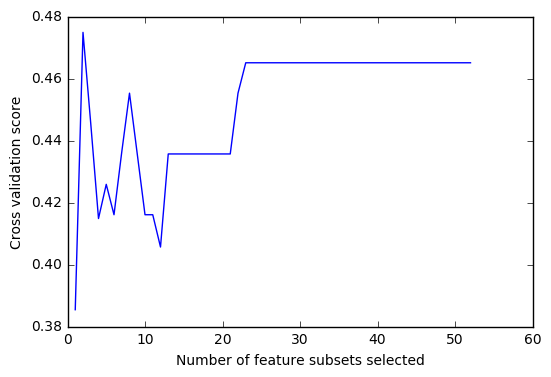

In [8]:
best_estimator = clf.best_estimator_

print("Optimal number of features : %d" % best_estimator.n_features_)
print("Recursive Feature Elimination (RFE) eliminated %d features" % (X.shape[1] - best_estimator.n_features_))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of feature subsets selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(best_estimator.grid_scores_) + 1), best_estimator.grid_scores_)
plt.show()

None


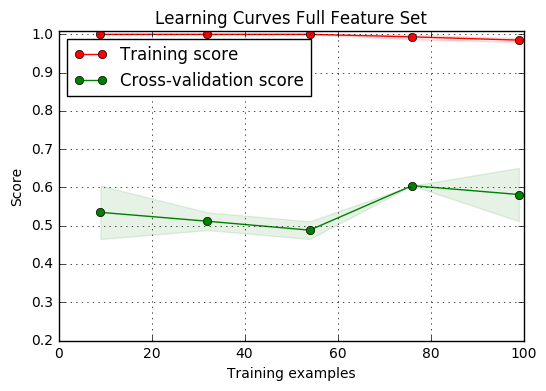

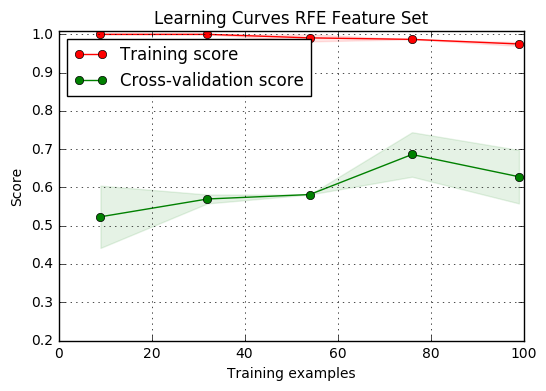

In [9]:
%matplotlib inline
from learning_curves import plot_learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

def create_learning_curve(title, model):
    cv = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=random_state)                                     
    plot_learning_curve(model, title, X, y, (0.2, 1.01), cv=cv, n_jobs=1)
    
create_learning_curve("Learning Curves Full Feature Set", lr)
create_learning_curve("Learning Curves RFE Feature Set", best_estimator.estimator_)

plt.show()

## Make predictions based on the model

In [15]:
from classification_metrics import classification_metrics

predicted = best_estimator.predict(X_test)
classification_metrics(y_test, predicted, patient_groups)

Accuracy was 67.44%

             precision    recall  f1-score   support

    control       0.67      0.78      0.72        18
      viral       0.67      0.62      0.64        13
  bacterial       0.70      0.78      0.74         9
     fungal       0.00      0.00      0.00         3

avg / total       0.63      0.67      0.65        43

Confusion Matrix: cols = predictions, rows = actual

                       control          viral      bacterial         fungal
        control             14              2              2              0
          viral              4              8              1              0
      bacterial              1              1              7              0
         fungal              2              1              0              0


## Review model predictions

In [16]:
probs = np.array(clf.predict(X_test))

d = {"Predicted": [patient_groups[i] for i in probs],
     "Actual": [patient_groups[i] for i in y_test]}

patient_df = pd.DataFrame(d, index=X_test.index)
patient_df.sort_values(by="Actual")

,Actual,Predicted
MN_223,bacterial,bacterial
MNC.074,bacterial,bacterial
MN_224,bacterial,viral
MN_304,bacterial,bacterial
MN_324,bacterial,bacterial
MN_140,bacterial,bacterial
MNC.112,bacterial,control
MNC.473,bacterial,bacterial
MN_208,bacterial,bacterial
MNC.592,control,control


## Review patients the model misclassified

In [17]:
patient_df[patient_df["Predicted"] != patient_df["Actual"]]

,Actual,Predicted
MN_138,fungal,control
MNC.116,control,viral
MNC.475,viral,bacterial
MNC.215,viral,control
MNC.674,viral,control
MNC.331,viral,control
MN_368,control,bacterial
MNC.112,bacterial,control
MN_222,fungal,viral
MNC.054,control,viral
